### 6.4 다중공선성과 변수 선택

In [1]:
# 미국 거시경제지표

In [1]:
from statsmodels.datasets.longley import load_pandas
dfy = load_pandas().endog
dfx = load_pandas().exog
df = pd.concat([dfy, dfx], axis=1)

In [2]:
sns.pairplot(dfx)
plt.show()

In [2]:
dfx.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


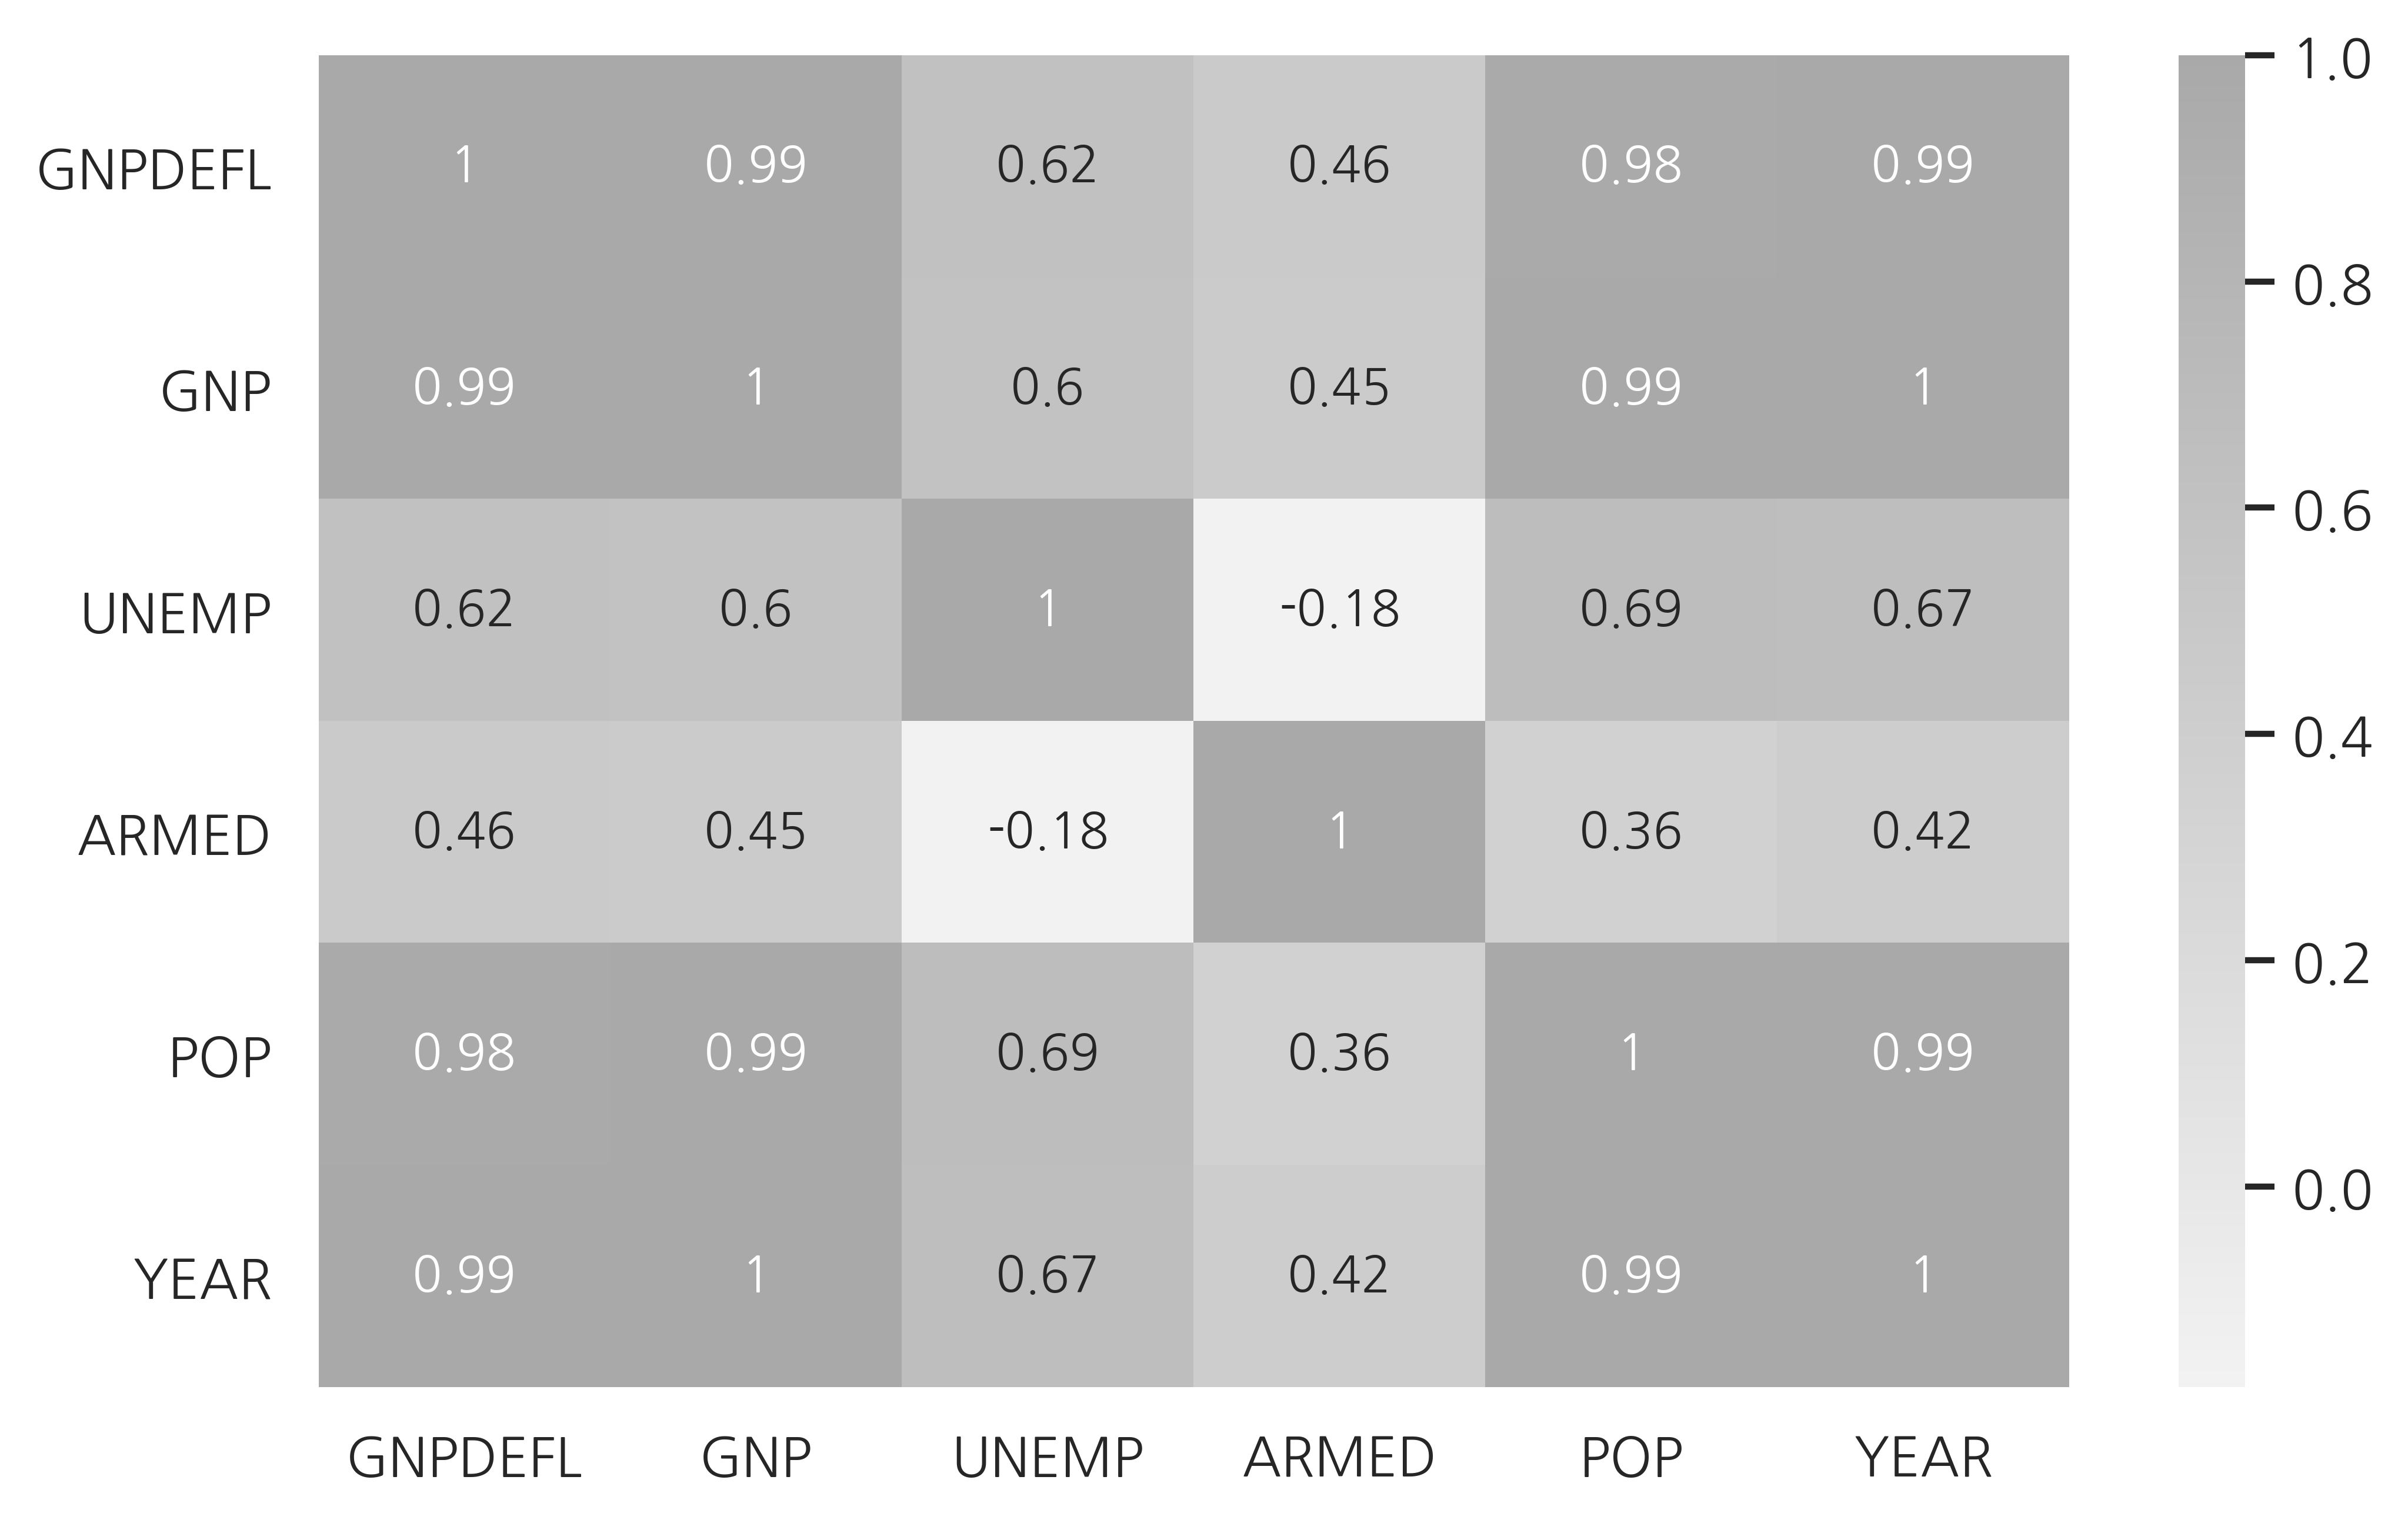

In [3]:
cmap = sns.light_palette('darkgray', as_cmap=True)
sns.heatmap(dfx.corr(), annot=True, cmap=cmap)
plt.show()

In [4]:
col = list(dfx.columns)
col

['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP', 'YEAR']

In [5]:
from sklearn.model_selection import train_test_split


def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=.5, random_state=seed)
    model = sm.OLS.from_formula('TOTEMP ~ ' + ' + '.join(col), data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Wed, 11 Mar 2020   Prob (F-statistic):             0.0366
Time:                        22:44:48   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

- 다중공선성이 높아 condition no.가 크고 
- 변수가 많아서? R squared가 1로 아주 완벽하게 모델링 되었지만
- overfitting의 가능성이 높음

In [6]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))
test1

[0.9815050656838765,
 0.9738497543105545,
 0.9879366369946689,
 0.7588861967924712,
 0.9807206089304135,
 0.8937889315133228,
 0.8798563810624284,
 0.931466577898656,
 0.8608525682178398,
 0.967719873512799]

#### VIF
- 다른 독립변수에 의존하는 변수 삭제
- $VIF_i \propto {1 \over 1 - R_i^2}$

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(
    dfx.values, i) for i in range(dfx.shape[1])]
vif['features'] = dfx.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [8]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=.5, random_state=seed)
    model = sm.OLS.from_formula(
        'TOTEMP ~ scale(GNP) + scale(UNEMP) + scale(ARMED)', data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           0.000231
Time:                        22:44:50   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

In [9]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))
test2

[0.9763608388904901,
 0.9841984331185696,
 0.9687069366140132,
 0.9397304053201787,
 0.9773357061188461,
 0.9561262155732317,
 0.9803852496698645,
 0.9917361722470804,
 0.983713406763946,
 0.9789512977093207]

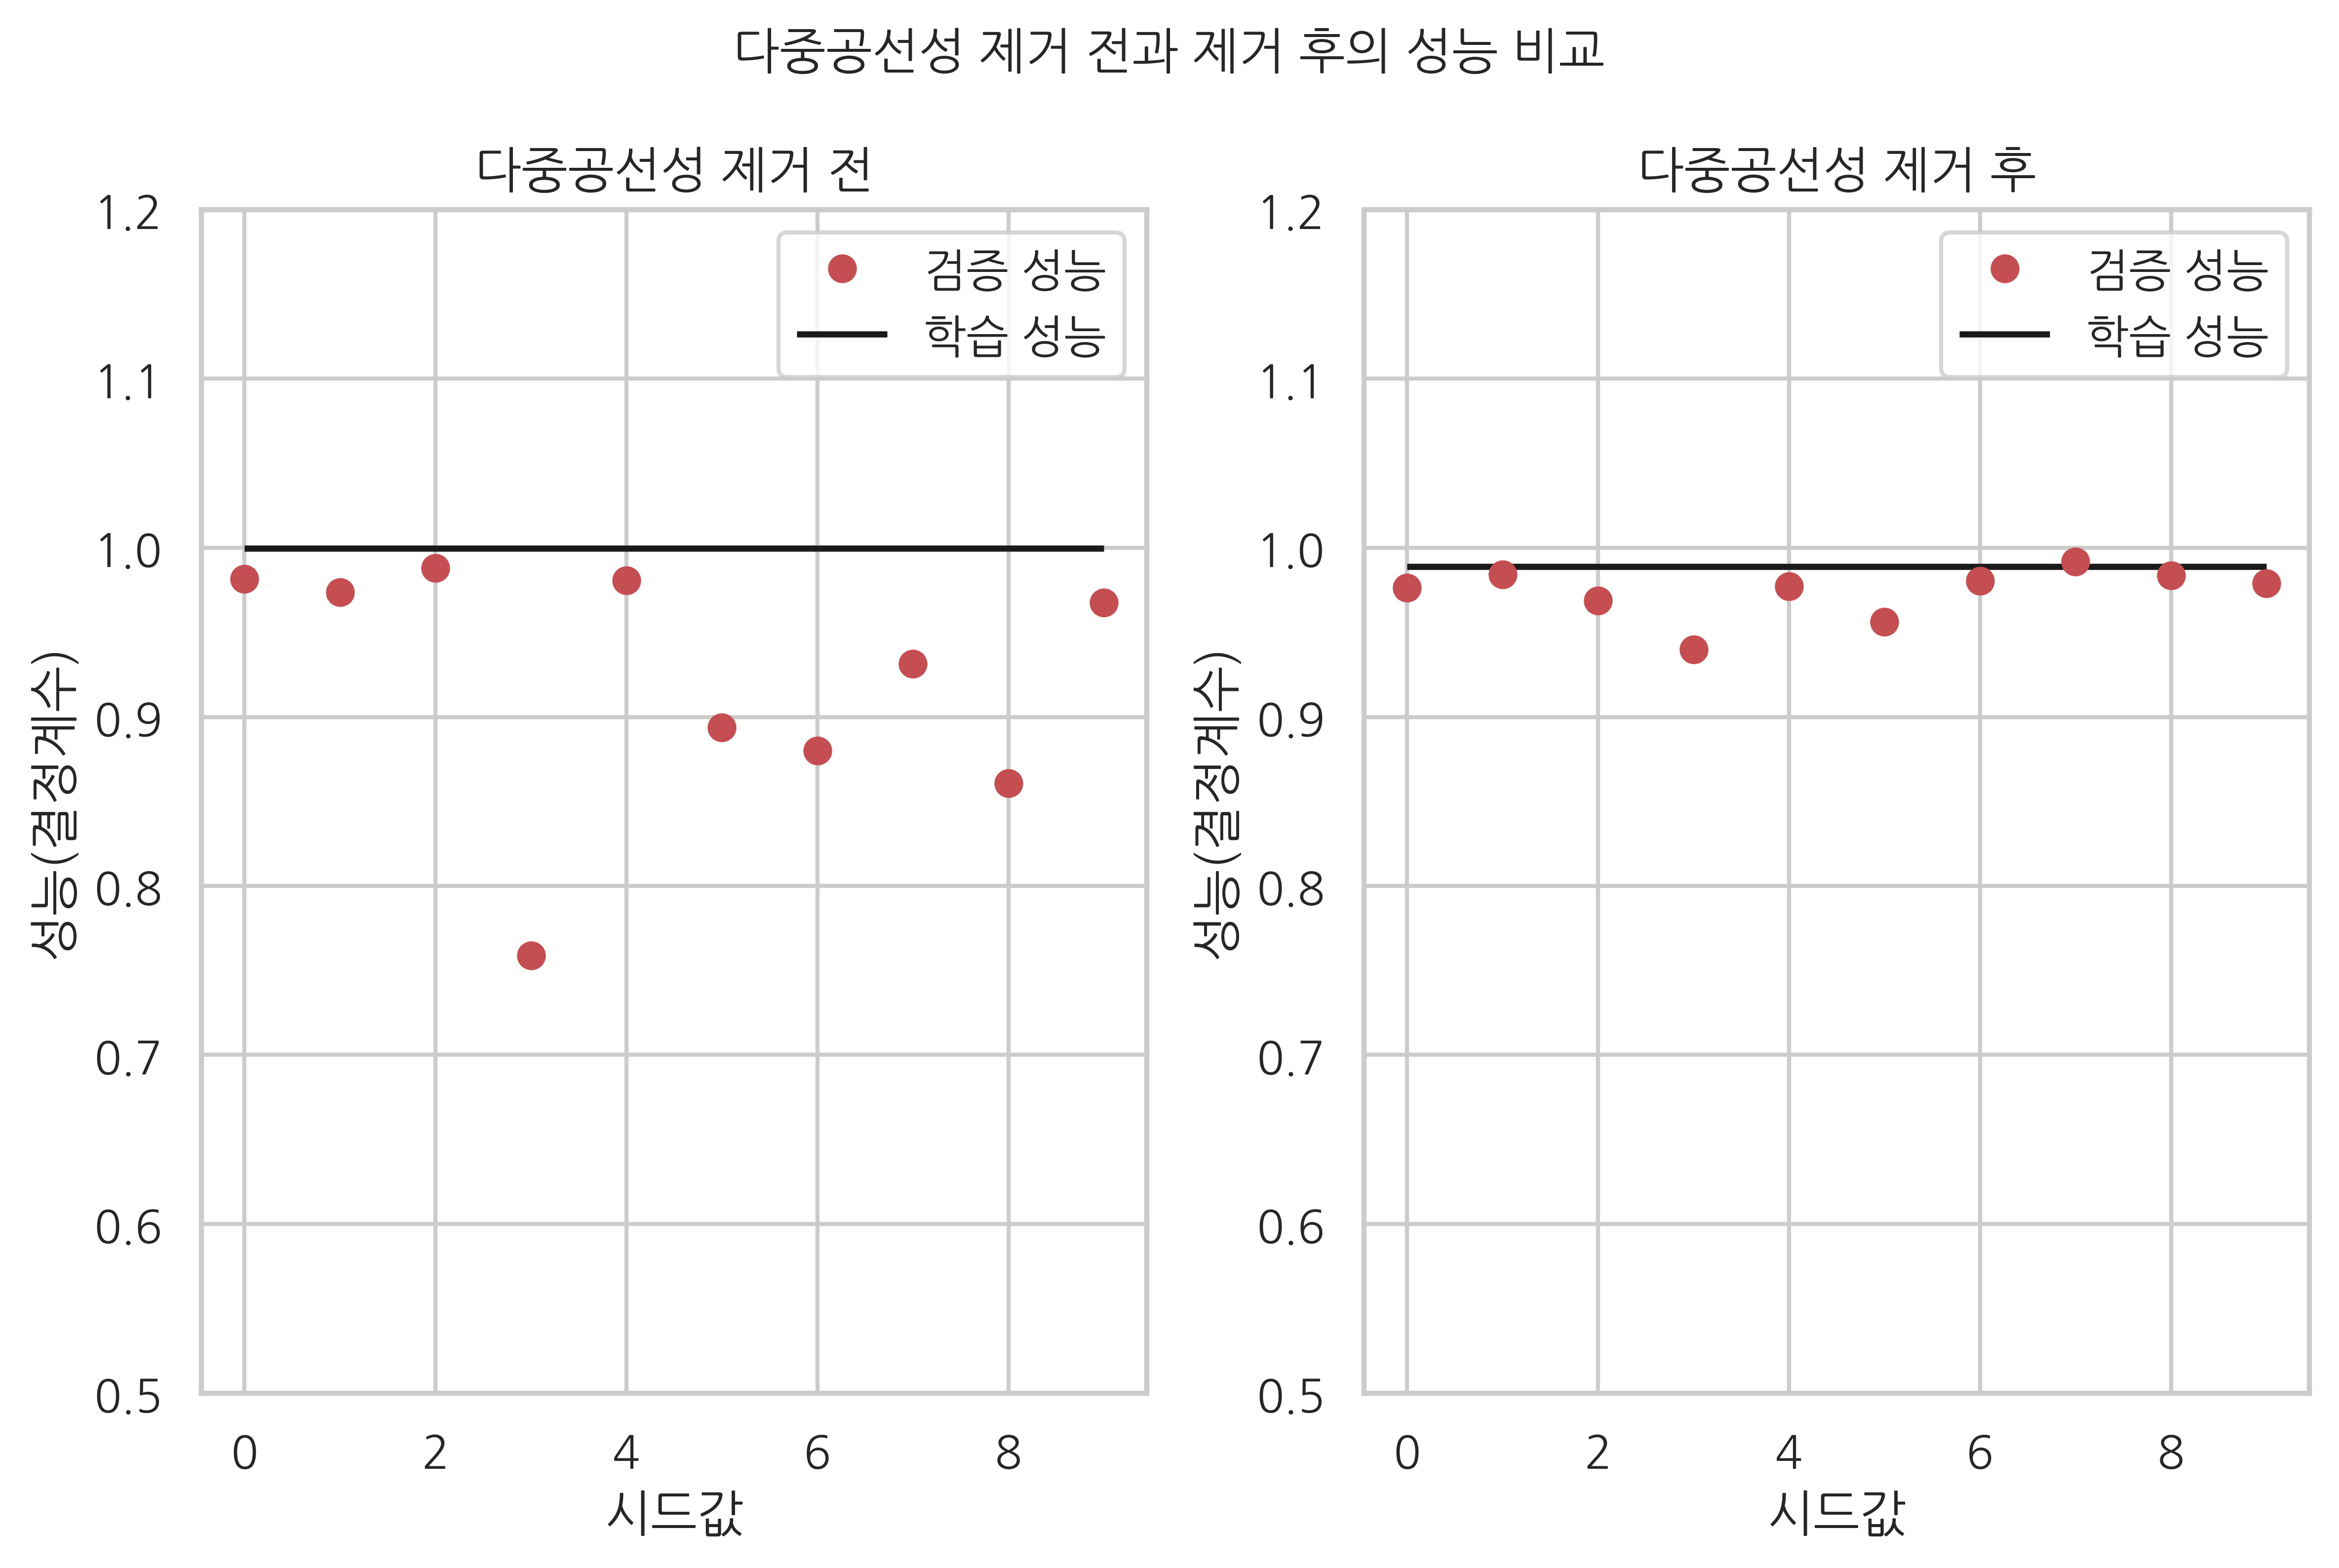

In [13]:
plt.subplot(121)
plt.plot(test1, 'ro', label='검증 성능')
plt.hlines(result1.rsquared, 0, 9, label='학습 성능')
plt.legend()
plt.xlabel('시드값')
plt.ylabel('성능(결정계수)')
plt.title('다중공선성 제거 전')
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(test2, 'ro', label='검증 성능')
plt.hlines(result2.rsquared, 0, 9, label='학습 성능')
plt.legend()
plt.xlabel('시드값')
plt.ylabel('성능(결정계수)')
plt.title('다중공선성 제거 후')
plt.ylim(0.5, 1.2)

plt.suptitle('다중공선성 제거 전과 제거 후의 성능 비교', y=1.05)
plt.tight_layout()
plt.show()